In [1]:
import time
import numpy as np
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from autocorrect import Speller
from nltk.tokenize import word_tokenize as wt 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn import metrics

# Dataset 3- SMS Spam Collection Dataset


## 3.a

This is the third and final dataset explored for this project. It contains 5574 samples of text messages labeled as Spam or Ham, with Ham meaning not spam. 

For this dataset, I will be utilizing Gaussian Naive Bayes, K-Nearest Neighbor (KNN), and Quadratic Discriminant Analysis (QDA)

In [2]:
## Importing the Dataset ##

sms_spam = pd.read_csv('Dataset3/SMSSpamCollection.csv')

print(sms_spam.shape)
sms_spam

(5574, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will Ã¼ b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [3]:
sms_spam.groupby('Label').count()

,SMS
Label,
ham,4827
spam,747


We can see the amount of SMS that are labeled as Ham, and Spam

Albeit loading the Dataset onto a Pandas DataFrame, our work is still not over. We are trying to detect spam, and this would not work if any new SMS came in, there needs to be a way to detect the words in it. I will show how this is done in the Pre Processing stage. 

## 3.b Pre Processing

As mentioned previosly, this dataset cannot function in its current form, so I need to use what is known as a Bag of Words model in order to properly use it. <br>

When working with text classification, it is important to remove any unwanted characters, such as punctuation or numbers as they will not be necessary. Additionally, all words must be converted to lowercase, just so that there are no word repetitions (i.e **Guy** and **guy** should be counted as the same, and not different). <br>

I will also be splitting this data into testing and training data. The test data will remain untouched, while the training data will be manipulated.

In [12]:
stemmer = PorterStemmer()
spell = Speller(lang='en')

data = []

for i in range(sms_spam.shape[0]):
    sms = sms_spam.iloc[i, 1]

    # remove non alphabatic characters
    sms = re.sub('[^A-Za-z]', ' ', sms)

    # make words lowercase, because Go and go will be considered as two words
    sms = sms.lower()

    # tokenising
    tokenized_sms = wt(sms)

    # remove stop words and stemming
 
    sms_processed = []
    for word in tokenized_sms:
        if word not in set(stopwords.words('english')):
            sms_processed.append(spell(stemmer.stem(word)))

    sms_text = " ".join(sms_processed)
    data.append(sms_text)

# creating the feature matrix 
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(data).toarray()
y = sms_spam.iloc[:, 0]

# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Naive Bayes 
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# predict class
y_pred = classifier.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)


In [15]:
print(X.shape)
print(X)

(5574, 1000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
# make all lowercase
sms_spam['SMS'] = sms_spam['SMS'].str.lower()

# remove all punctuations
sms_spam['SMS'] = sms_spam['SMS'].str.replace('[^a-zA-Z]', ' ')

In [22]:
sms_spam

,Label,SMS
0,ham,go until jurong point crazy available only ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i don t think he goes to usf he lives aro...
...,...,...
5569,spam,this is the nd time we have tried contact u...
5570,ham,will b going to esplanade fr home
5571,ham,pity was in mood for that so any other s...
5572,ham,the guy did some bitching but i acted like i d...


In [26]:
vectorizer = CountVectorizer(max_features=1000)

x2 = vectorizer.fit_transform(sms_spam['SMS'].values)

words_list = vectorizer.get_feature_names()
X2 = x2.toarray()
y2 = sms_spam.iloc[:, 0]

In [27]:
if X.all() == X2.all():
    print("Radical")
else:
    print("Yikes")

Radical


Now the data is ready to be utilized by the Machine Learning Methods that will be used. 

## 3.c Feature Extraction

For feature extraction, Principal Component Alalysis will be used in order to reduce the dimensionality of the data. 

Text(0.5, 0.91, '90% capture')

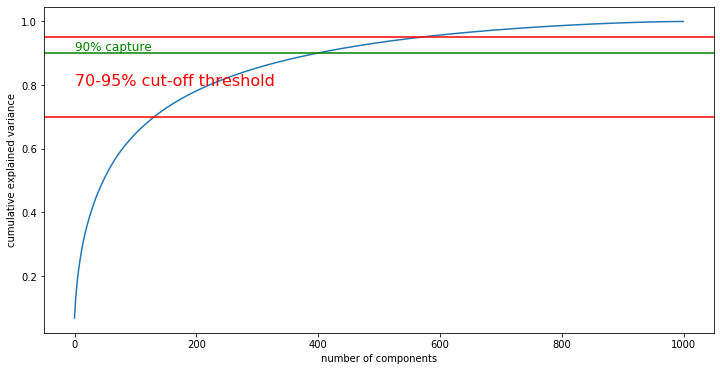

In [44]:
pca = PCA().fit(X2.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axhline(y=0.70, color='r', linestyle='-')
plt.axhline(y=0.9, color='g', linestyle='-') # capture 90% of the energy 
plt.text(0.5, 0.8, '70-95% cut-off threshold', color = 'red', fontsize=16)
plt.text(0.5, 0.91, '90% capture', color = 'green', fontsize=12)

In [11]:
sms_pca = skldecomp.PCA(n_components=0.85, svd_solver='full')
sms_features = sms_pca.fit_transform(sms_bow)
print("HAR: ",sms_features.shape)

## 3.d Processing the Datasets

### 3.d.i Naive Bayes Classifier

### 3.d.ii K-Nearest Neighbor (K-NN) Classifier

### 3.d.iii Logistic Regression

## 3.e Comparative Analysis

## 3.f Ethical Issues

## 3.g References used in this Dataset

- https://towardsdatascience.com/how-to-build-and-apply-naive-bayes-classification-for-spam-filtering-2b8d3308501
- https://medium.com/swlh/text-classification-using-the-bag-of-words-approach-with-nltk-and-scikit-learn-9a731e5c4e2f\
- https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
- https://builtin.com/data-science/step-step-explanation-principal-component-analysis